<a href="https://colab.research.google.com/github/Stanfording/small_GAN_testing/blob/main/64_cele_small_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Goal:   Just get a small GAN running



Get the preprocessed celebHD data from google drive

In [114]:
# #Download the dataset
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN" -O "proCeleba.zip" && rm -rf /tmp/cookies.txt

# #unzip the dataset
# !unzip "/content/proCeleba.zip"

# #remove unnecessary files
# !rm -rf /content/__MACOSX

## Import libraries

### Install oneflow framework

In [115]:
#!python3 -m pip install -f https://release.oneflow.info oneflow==0.7.0+cu102

In [116]:
#import oneflow as t

In [117]:
from tqdm import tqdm

from torch.autograd import Variable, grad
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import os
import torch as t
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from skimage import io
import copy

### Set initial hyperparameters

In [118]:

batch_size = 64

resolution = 16

img_fold_dir_64_reso = f"/content/proCeleba/{resolution}"

iteration = 200

critic = 5          #Train generator 5 times per epoch

eval_size = 25

laten_space = 100

updatD_step = critic - 4

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

log_folder = "log"
!mkdir "log"
!mkdir "log/checkpoint"
!mkdir "log/sample"

mkdir: cannot create directory ‘log’: File exists
mkdir: cannot create directory ‘log/checkpoint’: File exists
mkdir: cannot create directory ‘log/sample’: File exists


### Show me which gpu I am using.

In [119]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fbc9b77a-d009-7001-6a9e-b01b0c01b631)


### Pre loading the data

In [120]:
# Define a data class for load unclassfied data.
class Get_No_Classes_Img_Dataset(Dataset):
    
    def __init__(self, folder_dir, transform = None):
        self.folder_dir = os.path.join(folder_dir)
        self.transform = transform
        self.image_list = os.listdir(self.folder_dir)
        
    def __len__(self):
        return len(os.listdir(self.folder_dir))
    
    def __getitem__(self, index):
        
        image_name = self.image_list[index]
        
        image_dir = os.path.join(self.folder_dir, image_name)
        
        image = io.imread(image_dir)
        
        if (self.transform != None):
            image = self.transform(image)
        
        return image
    

transform = transforms.ToTensor() #From Batch * Highth * Width * Channel to Batch * Channel * Highth * Width
                                  #Which is what pytorch CNN can work with.

dataset = Get_No_Classes_Img_Dataset(img_fold_dir_64_reso, transform = transform) 
                                                            # datasets[0].shape = (16,16,3)
                                                            # len(datasets) = 28000
total_data_len = len(dataset)
                                                                                            
#datasets_batched = DataLoader(datasets, batch_size = batch_size) #loader is renewed every epoch




```
loader = iter(loader)
print(next(loader).shape) 
```
will output


```
torch.Size([batch_size, 3, resolution, resolution])
```

So data loading is ready.

What's left is keep using 

```
next(loader)
```
to access each batch of data


### Visualize a picture

In [121]:
from IPython.display import Image, display




# Viewing one data sample function:
def showOneImge(img, i, shouldSave):
    
    img = img.squeeze()
    
    img = transforms.ToPILImage()(img)
    
    plt.figure(figsize = (10,10), dpi = 10)
    plt.axis('off')
    
    if shouldSave:
      saveDir = f'{log_folder}/sample/{str(i).zfill(6)}.png'
      plt.imshow(img)
      plt.savefig(saveDir, bbox_inches='tight', pad_inches = 0)
      img = Image(saveDir)
      display(img)
    else:
      deleteDir = f"{log_folder}/sample/Delete.png"
      plt.imshow(img)
      plt.savefig(deleteDir, bbox_inches='tight', pad_inches = 0)
      img = Image(deleteDir)
      display(img)
      !rm "/content/log/sample/Delete.png"
    return 

''' Testing showOneImage'''
# loader = DataLoader(datasets, batch_size = batch_size)

# data = iter(loader)

# oneSample = next(data)[0]

# showOneImge(oneSample, 9999, True)


def showMoreImages(img, num):

  subplot_x = int(num ** (1/2))
  subplot_y = num // subplot_x
  plt.figure(figsize = (2,2))
  for i in range(len(img)):
      aimg = transforms.ToPILImage()(img[i])
      plt.subplot(subplot_x, subplot_y, i+1)
      plt.imshow(aimg)
      plt.axis('off')


-------------------------------------------------

### Now Designing the simple GAN network

In [122]:
"""
Define the generator
"""

class G(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.laten = nn.Sequential(
            nn.Linear(laten_space, 100),
            nn.Linear(100, 500),
            nn.Linear(500, 128 * resolution * resolution))

        self.model = nn.Sequential(
            nn.Conv2d(128, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 3, (3, 3), padding = "same"),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, theInput, batch_size):
        
        x = self.laten(theInput)
        
        x = t.reshape(x, (batch_size, 128, resolution, resolution))
         
        x = self.model(x)
            
            
        return x
    
class D(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.netWork = nn.Sequential(
            nn.Conv2d(3, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, (3, 3), stride = (3, 3)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 1, (3, 3), stride = (3, 3)),
            nn.Flatten())
        
    def forward(self, theInput):
        
        return self.netWork(theInput)

### Testing the network

In [123]:
"""

Testing the net work:

"""

# oneImg = next(iter(datasets))[0]

# showOneImge(oneImg, 0)

# oneImg = oneImg.expand(1,3,64,64)

# print(oneImg.shape)

# print(oneImg)

# #img into G to test shape

# input_noise_example = t.randn((batch_size, 1, 1, 5))

# a = G()(input_noise_example, batch_size)
# print(a[0])
# showOneImge(a[0], 0)

# b = D()(next(loader))

# print(b.shape)

'\n\nTesting the net work:\n\n'

### Gradient Penalty from wGAN, will test later.

In [124]:
def compute_gradient_penalty(D, real_samples, fake_samples, current_batch_size):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = t.randn((current_batch_size, 1, 1, 1)).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    
    d_interpolates = D(interpolates)
    
    
    grad_x_hat = grad(
            outputs=d_interpolates.sum(), inputs=interpolates, create_graph=True)[0]
    grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1)
                      .norm(2, dim=1) - 1)**2).mean()
    grad_penalty = 10 * grad_penalty
    
    return grad_penalty

### Initializing the generator, discriminator, optimizer, labels, and loss.

In [125]:
generator = G().to(device)
discriminator = D().to(device)
discriminatorReal = D().to(device)

G_optimizer = t.optim.Adam(generator.parameters(), lr = 0.00001)
D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.00001)

label_real = t.ones((batch_size, 1)).to(device)
label_fake = t.zeros((batch_size, 1)).to(device)

bceLoss = nn.BCEWithLogitsLoss()

should_train_G = True #True = train d, False = train g

### Train decider

In [126]:
def what_to_train(fake_score, real_score, should_train_G):
  last_should_train_G = should_train_G


  if (fake_score < real_score * score_dif):
    return True

  if last_should_train_G:
    if (fake_score > real_score * (1 - score_dif)):
      return False
    else:
      return True

  return False


  
  



### Start training

Epoch: 1: 100%|██████████| 438/438 [00:19<00:00, 22.72it/s, D_total_loss=-1.3, G_loss=0.742, fake_score=-.608, real_score=0.79]


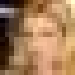

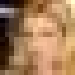

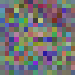

epoch =  1
Epoch [0/200], Step [438/438], d_loss: -1.3044, g_loss: 0.7418, D(x): 0.79, D(G(z)): -0.61


Epoch: 3: 100%|██████████| 438/438 [00:19<00:00, 22.97it/s, D_total_loss=-1.79, G_loss=2.86, fake_score=-2.89, real_score=-.927]


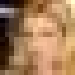

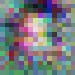

epoch =  3
Epoch [2/200], Step [438/438], d_loss: -1.7871, g_loss: 2.8594, D(x): -0.93, D(G(z)): -2.89


Epoch: 5: 100%|██████████| 438/438 [00:19<00:00, 22.02it/s, D_total_loss=-2.44, G_loss=3.28, fake_score=-3.36, real_score=-.644]


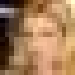

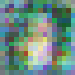

epoch =  5
Epoch [4/200], Step [438/438], d_loss: -2.4362, g_loss: 3.2753, D(x): -0.64, D(G(z)): -3.36


Epoch: 7: 100%|██████████| 438/438 [00:20<00:00, 21.13it/s, D_total_loss=-2.52, G_loss=1.94, fake_score=-1.99, real_score=0.65]


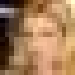

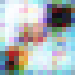

epoch =  7
Epoch [6/200], Step [438/438], d_loss: -2.5157, g_loss: 1.9418, D(x): 0.65, D(G(z)): -1.99


Epoch: 9: 100%|██████████| 438/438 [00:20<00:00, 21.70it/s, D_total_loss=-1.39, G_loss=1.91, fake_score=-1.61, real_score=-.0341]


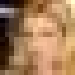

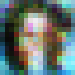

epoch =  9
Epoch [8/200], Step [438/438], d_loss: -1.3877, g_loss: 1.9068, D(x): -0.03, D(G(z)): -1.61


Epoch: 11: 100%|██████████| 438/438 [00:19<00:00, 22.46it/s, D_total_loss=-1.34, G_loss=1.1, fake_score=-.879, real_score=0.915]


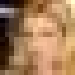

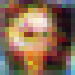

epoch =  11
Epoch [10/200], Step [438/438], d_loss: -1.3449, g_loss: 1.0993, D(x): 0.91, D(G(z)): -0.88


Epoch: 13: 100%|██████████| 438/438 [00:19<00:00, 22.17it/s, D_total_loss=-1.38, G_loss=0.81, fake_score=-.97, real_score=0.535]


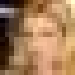

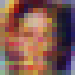

epoch =  13
Epoch [12/200], Step [438/438], d_loss: -1.3806, g_loss: 0.8100, D(x): 0.54, D(G(z)): -0.97


Epoch: 15: 100%|██████████| 438/438 [00:19<00:00, 22.36it/s, D_total_loss=-.102, G_loss=0.552, fake_score=-.424, real_score=0.91]


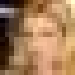

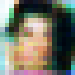

epoch =  15
Epoch [14/200], Step [438/438], d_loss: -0.1015, g_loss: 0.5520, D(x): 0.91, D(G(z)): -0.42


Epoch: 17: 100%|██████████| 438/438 [00:19<00:00, 22.22it/s, D_total_loss=-.942, G_loss=0.364, fake_score=-.0932, real_score=1.02]


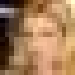

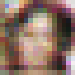

epoch =  17
Epoch [16/200], Step [438/438], d_loss: -0.9420, g_loss: 0.3640, D(x): 1.02, D(G(z)): -0.09


Epoch: 19: 100%|██████████| 438/438 [00:19<00:00, 22.18it/s, D_total_loss=-.469, G_loss=0.191, fake_score=-.358, real_score=0.387]


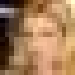

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


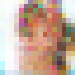

epoch =  19
Epoch [18/200], Step [438/438], d_loss: -0.4687, g_loss: 0.1912, D(x): 0.39, D(G(z)): -0.36


Epoch: 21: 100%|██████████| 438/438 [00:19<00:00, 22.18it/s, D_total_loss=-.493, G_loss=0.362, fake_score=0.174, real_score=0.736]


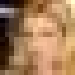

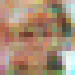

epoch =  21
Epoch [20/200], Step [438/438], d_loss: -0.4928, g_loss: 0.3620, D(x): 0.74, D(G(z)): 0.17


Epoch: 23: 100%|██████████| 438/438 [00:19<00:00, 22.03it/s, D_total_loss=-.74, G_loss=0.245, fake_score=-.116, real_score=0.697]


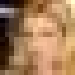

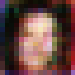

epoch =  23
Epoch [22/200], Step [438/438], d_loss: -0.7403, g_loss: 0.2453, D(x): 0.70, D(G(z)): -0.12


Epoch: 25: 100%|██████████| 438/438 [00:19<00:00, 22.07it/s, D_total_loss=-.391, G_loss=-.376, fake_score=0.367, real_score=0.836]


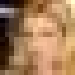

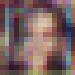

epoch =  25
Epoch [24/200], Step [438/438], d_loss: -0.3913, g_loss: -0.3756, D(x): 0.84, D(G(z)): 0.37


Epoch: 27: 100%|██████████| 438/438 [00:19<00:00, 22.12it/s, D_total_loss=-.0945, G_loss=-.231, fake_score=0.579, real_score=0.75]


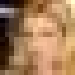

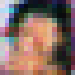

epoch =  27
Epoch [26/200], Step [438/438], d_loss: -0.0945, g_loss: -0.2306, D(x): 0.75, D(G(z)): 0.58


Epoch: 29: 100%|██████████| 438/438 [00:20<00:00, 21.83it/s, D_total_loss=-.351, G_loss=-.49, fake_score=0.565, real_score=1.06]


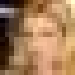

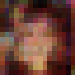

epoch =  29
Epoch [28/200], Step [438/438], d_loss: -0.3515, g_loss: -0.4904, D(x): 1.06, D(G(z)): 0.57


Epoch: 31: 100%|██████████| 438/438 [00:19<00:00, 21.93it/s, D_total_loss=0.505, G_loss=-.409, fake_score=0.0765, real_score=0.944]


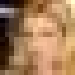

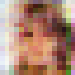

epoch =  31
Epoch [30/200], Step [438/438], d_loss: 0.5054, g_loss: -0.4093, D(x): 0.94, D(G(z)): 0.08


Epoch: 33: 100%|██████████| 438/438 [00:20<00:00, 21.41it/s, D_total_loss=-.35, G_loss=-.318, fake_score=0.265, real_score=1.03]


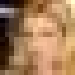

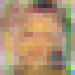

epoch =  33
Epoch [32/200], Step [438/438], d_loss: -0.3502, g_loss: -0.3183, D(x): 1.03, D(G(z)): 0.26


Epoch: 35: 100%|██████████| 438/438 [00:20<00:00, 21.68it/s, D_total_loss=-.369, G_loss=-.147, fake_score=0.115, real_score=0.791]


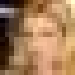

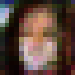

epoch =  35
Epoch [34/200], Step [438/438], d_loss: -0.3689, g_loss: -0.1470, D(x): 0.79, D(G(z)): 0.11


Epoch: 37: 100%|██████████| 438/438 [00:20<00:00, 21.75it/s, D_total_loss=-.498, G_loss=-.254, fake_score=0.439, real_score=1.15]


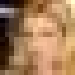

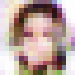

epoch =  37
Epoch [36/200], Step [438/438], d_loss: -0.4985, g_loss: -0.2540, D(x): 1.15, D(G(z)): 0.44


Epoch: 39: 100%|██████████| 438/438 [00:20<00:00, 21.82it/s, D_total_loss=0.0669, G_loss=-.585, fake_score=0.921, real_score=1.09]


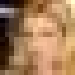

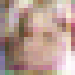

epoch =  39
Epoch [38/200], Step [438/438], d_loss: 0.0669, g_loss: -0.5852, D(x): 1.09, D(G(z)): 0.92


Epoch: 41: 100%|██████████| 438/438 [00:20<00:00, 21.50it/s, D_total_loss=-.748, G_loss=-.821, fake_score=0.731, real_score=1.6]


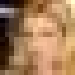

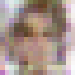

epoch =  41
Epoch [40/200], Step [438/438], d_loss: -0.7485, g_loss: -0.8209, D(x): 1.60, D(G(z)): 0.73


Epoch: 43: 100%|██████████| 438/438 [00:20<00:00, 21.75it/s, D_total_loss=-.639, G_loss=-.539, fake_score=0.51, real_score=1.22]


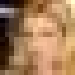

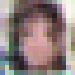

Epoch: 45: 100%|██████████| 438/438 [00:20<00:00, 21.60it/s, D_total_loss=-.835, G_loss=-.593, fake_score=0.412, real_score=1.37]


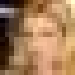

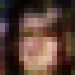

epoch =  45
Epoch [44/200], Step [438/438], d_loss: -0.8351, g_loss: -0.5930, D(x): 1.37, D(G(z)): 0.41


Epoch: 47:  91%|█████████ | 398/438 [00:18<00:01, 21.95it/s, D_total_loss=-.541, G_loss=0.0199, fake_score=-.0437, real_score=1.04]

In [ ]:
for i in range(iteration):

    p = tqdm(range(total_data_len // batch_size + 1)) # This is a progress bar run on each epoch
    
    datasets_batched = DataLoader(dataset, batch_size = batch_size)
    
    loader = iter(datasets_batched)

    # real_score = t.Tensor(2)

    # fake_score = t.Tensor(2)

    # g_fake_loss = t.Tensor([2])

    # g_total_loss = 0

    d_step = 0

    for j in p:
        

        batchNum = str(i+1)
        
        #Training the D
        #real data
        real = next(loader).to(device)

        #current_batch size (the last batch is different than others)
        current_batch_size, c, h, w = real.shape
        #labels
        label_real = 0.1 * t.randint(7,10,(current_batch_size,1)).type(t.half)
        label_fake = 0.1 * t.randint(0,3,(current_batch_size,1)).type(t.half)

        real_score = discriminator(real)
        d_real_loss = -t.mean(real_score)
        
        input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
        fake = generator(input_noise, current_batch_size)
        fake_score = discriminator(fake)

        d_fake_loss = t.mean(fake_score)

        gradient_penalty = compute_gradient_penalty(discriminator, real, fake, current_batch_size)
        
        total_loss = d_fake_loss + d_real_loss + gradient_penalty

        generator.zero_grad()
        discriminator.zero_grad()
        total_loss.backward()
        D_optimizer.step()

        d_step += 1

        if d_step == updatD_step:

          discriminatorReal.load_state_dict(discriminator.state_dict().copy())




        if j % critic == 0:
          input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
          fake = generator(input_noise, current_batch_size)
          fake_score = discriminator(fake)
          g_fake_loss = -t.mean(fake_score)
          discriminator.zero_grad()
          generator.zero_grad()
          g_fake_loss.backward()
          G_optimizer.step()
          discriminator.load_state_dict(discriminatorReal.state_dict().copy())
          D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.00001)
          d_step = 0
          

        
        mse = "Epoch: " + batchNum
        
        p.set_description(mse)
            
        p.set_postfix(G_loss = g_fake_loss.item(), D_total_loss = total_loss.item(), real_score = real_score.mean().item(), fake_score = fake_score.mean().item())
        
    if i == 0:
        showOneImge(real[0], 99999, True)   
    
    if i % 2 == 0:
      
      showOneImge(real[0], 99999, False)
      showOneImge(fake[0], i, False)
      print("epoch = ", i + 1)  
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(i, iteration, j+1, total_data_len // batch_size + 1, total_loss.item(), g_fake_loss.item(), real_score.mean().item(), fake_score.mean().item()))      
      

    if i % 50 == 0:
      t.save(generator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_g.model')
      t.save(discriminator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_d.model')


### Show Result

In [ ]:


#Generated
generator.eval()

with t.no_grad():
  input_noise = t.normal(0, 1, size = (eval_size, 1, 1, laten_space)).to(device)
  generated = generator(input_noise, eval_size)
  showMoreImages(generated, eval_size)

#Real
datasets_batched = DataLoader(dataset, batch_size = eval_size)
loader = iter(datasets_batched)
real = next(loader)
showMoreImages(real, eval_size)

### remove log file when necessarry

In [ ]:
# !rm -rf /content/log/checkpoint

# !mkdir /content/log/checkpoint

# !rm -rf /content/log/sample
# !mkdir /content/log/sample

# from google.colab import files
# files.download('/content/log') 